In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch.autograd import Variable
from torchsummary import summary

from torchvision.utils import save_image
from IPython.core.display import Image, display

import numpy as np
import matplotlib.pyplot as plt
from vae import VAE

%load_ext autoreload
%autoreload 2

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# Truncated backpropagation
def detach(states):
    return [state.detach() for state in states] 

In [7]:
bsz = 20
epochs = 1
seqlen = 30

zsize = 32
nhidden = 256

In [8]:
z = torch.from_numpy(np.load('z.npy'))
z = z.view(bsz, -1, z.size(1)).to(device)
z.shape

torch.Size([20, 1500, 32])

In [11]:
class M(nn.Module):
    def __init__(self, nembed, nhidden=256, nlayers=1):
        super(M, self).__init__()

        self.nhidden = nhidden
        self.nlayers = nlayers
        
        self.lstm = nn.LSTM(nembed, nhidden, nlayers, batch_first=True)
        self.linear = nn.Linear(nhidden, nembed)
        
    def forward(self, x, h):
        # Forward propagate LSTM
        out, (h, c) = self.lstm(x, h)
        out = self.linear(out)
        return out, (h, c)
    
    def init_hidden(self, bsz):
        return (torch.zeros(self.nlayers, bsz, self.nhidden).to(device),
                torch.zeros(self.nlayers, bsz, self.nhidden).to(device))

In [10]:
model = M(zsize, nhidden).to(device)
model

M(
  (lstm): LSTM(32, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=32, bias=True)
)

In [8]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [9]:
# Train the model
for epoch in range(epochs):
    # Set initial hidden and cell states
    hidden = model.init_hidden(bsz)
    
    for i in range(0, z.size(1) - seqlen, seqlen):
        # Get mini-batch inputs and targets
        inputs = z[:, i:i+seqlen, :]
        targets = z[:, (i+1):(i+1)+seqlen, :]
        
        # Forward pass
        hidden = detach(hidden)
        outputs, hidden = model(inputs, hidden)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        model.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        
    if epoch % 50 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'
               .format(epoch+1, epochs, loss.item()))

Epoch [1/500], Loss: 0.2344
Epoch [51/500], Loss: 0.0190
Epoch [101/500], Loss: 0.0128
Epoch [151/500], Loss: 0.0099
Epoch [201/500], Loss: 0.0085
Epoch [251/500], Loss: 0.0075
Epoch [301/500], Loss: 0.0058
Epoch [351/500], Loss: 0.0053
Epoch [401/500], Loss: 0.0082
Epoch [451/500], Loss: 0.0046


In [10]:
# np.linalg.norm(z[0, 0, :].cpu().data - z1[0, :, :].cpu().data, axis=1)
# np.linalg.norm(inputs.cpu().data - targets.cpu().data)

### Test RNN next frame prediction

In [66]:
vae = VAE(image_channels=3).to(device)
vae.load_state_dict(torch.load('vae.torch', map_location='cpu'))

Current Frame				 Next Frame			 Next Frame Prediction


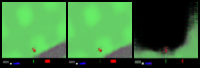

In [168]:
zero = np.random.randint(z.size(0))
one = np.random.randint(z.size(1))
z_in = z[zero:zero+1, one:one+1, :]
z_next = z[zero:zero+1, one+1:one+2, :]

hidden = model.init_hidden(1)
z_next_pred = model(z_in, hidden)[0]
# z_next_pred = torch.randn(1,1,32)

compare_x = torch.cat((vae.decode(z_in), vae.decode(z_next), vae.decode(z_next_pred)))

# compare_x = vae.decode(z_out)
save_image(compare_x.data.cpu(), 'sample_image.png')
print("Current Frame\t\t\t\t", "Next Frame\t\t\t", "Next Frame Prediction")
display(Image('sample_image.png', width=900, unconfined=True))